## Blog 6 Medium Series on Gaining an Analytics Edge using USAspending.gov Data

Exploration of the top 5 highest paid executives data in the USAspending.gov files.

In [273]:
# previous blog post - https://medium.com/@lulstrup/5-is-federal-spending-on-ai-growing-cbb2881cf0d3

In [1]:
# highly_compensated employee reporting - https://usaspending-help.zendesk.com/hc/en-us/articles/360001252274-Award-Data-Question-What-entites-are-required-to-include-Executive-Compensation-data-
# https://www.law.cornell.edu/cfr/text/48/52.204-10

# From USAspending.gov FAQs

# Per FFATA, entities must report the executive compensation of their five most highly compensated officers when the following three conditions are met:
# During the preceding fiscal year, the entity received 80 percent or more of its annual gross revenues from federal awards.
# The entity received $25M or more in annual gross revenues from federal awards.
# The public does not have access to the compensation information through periodic reports filed under the Securities and Exchange Act of 1934 or the Internal Revenue Code of 1986. 
# If these conditions aren’t met, recipients aren’t required to provide executive compensation data.

In [2]:
import os, glob, pathlib
import math
import shutil
from datetime import datetime
from collections import Counter
import zipfile
import pandas as pd
import numpy as np
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import psutil
import requests

import matplotlib
import matplotlib.pyplot as plt

# use import below to interactively select the folder where the USAspending Archives are located
# https://pypi.org/project/ipyfilechooser/
from ipyfilechooser import FileChooser
import random

In [3]:
matplotlib.style.use('ggplot')

In [4]:
# Use this to hide the names of the companies and people for display purposes
def Name_Scrambler(text):
    random_letters = random.sample(list(text), len(text))
    random_text = "".join(random_letters)
    random_text = " ".join([aWord.capitalize() for aWord in random_text.split()])
    return random_text.strip()

def Scramble_Company_Exec_Names(df):
    df_copy = df.copy()
    df_copy['recipient_parent_name'] = df_copy['recipient_parent_name'].apply(Name_Scrambler)
    for n in range(5):
        field_name = 'highly_compensated_officer_' + str(n+1) + '_name'
        if field_name in df_copy.columns:
            df_copy[field_name] = df_copy[field_name].apply(Name_Scrambler)
    return df_copy

Name_Scrambler("John Doe")

'Ono Jdhe'

In [5]:
def Display_System_Info(): # https://psutil.readthedocs.io/en/latest/#psutil.virtual_memory
    physical_cores = psutil.cpu_count(logical=False) #, psutil.cpu_count(logical=True)
    RAM_total_installed = psutil.virtual_memory()[0] #, psutil.swap_memory()
    RAM_available = psutil.virtual_memory().available #['available']
    dask_workers = int(physical_cores/2)
    print(f"Physical CPU Cores: {physical_cores}, RAM available: {round(RAM_available/1e9)} GB, total RAM: {round(RAM_total_installed/1e9)} GB")
    result_record = {'CPU_Cores_Physical' : physical_cores,
                    'RAM_available' : RAM_available,
                     'RAM_total_installed' : RAM_total_installed,
                    }
    return result_record

Display_System_Info()

Physical CPU Cores: 8, RAM available: 42 GB, total RAM: 69 GB


{'CPU_Cores_Physical': 8,
 'RAM_available': 41946275840,
 'RAM_total_installed': 68719476736}

In [6]:
def Get_Current_Time():
    return datetime.now().strftime("%d/%m/%Y %H:%M:%S")

Get_Current_Time()

'12/10/2020 11:09:26'

In [13]:
# this assumes the jupyter notebook is running in the same higher level directory
# where the USAspending.gov zip archives and the decompressed Zip files are stored

original_cwd = os.getcwd() # use this if  files are located in local directory where jupyter is running
# 
folder_choice = FileChooser(os.getcwd(),
                           title='<b>Choose Folder with USAspending.gov GFY Archive Expanded CSV Files:</b>',
                            show_hidden=False,
                            select_default=True,
                            use_dir_icons=True,
                            show_only_dirs=True)
display(folder_choice)

FileChooser(path='/Users/leifulstrup/Documents/Primehook/Marketing/Medium Blog Posts', filename='', title='HTM…

In [14]:
download_file_path_CSV = str(folder_choice.selected_path)

your_path_dummy = 'Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName'
#print(original_cwd)
print(os.path.join(your_path_dummy, "/".join(download_file_path_CSV.split('/')[-2:])))

Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName/USAspending_Archive_Downloads/Expanded_CSV_Files


In [15]:
def CurrentGFY():
    if datetime.now().month >= 10: 
        return datetime.now().year + 1
    else:
        return datetime.now().year
    
def Check_Archive_Filename_Format(filename_complete):
    base_filename = os.path.basename(filename_complete)
    # rule checks
    if not base_filename.startswith("FY"):
        return False
    if not base_filename.endswith(".zip") and not base_filename.endswith(".csv"):
        return False
    if " " in base_filename:
        return False
    if len(base_filename.split(".")) > 2:
        return False
    if "copy" in base_filename:
        return False
    
    return True

def Get_GFY_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    filename_GFY = os.path.basename(filename_to_check_complete_path)[:6]
    assert filename_GFY[:2] == 'FY' # check this
    return filename_GFY

def Get_ArchiveDate_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    basefilename = os.path.basename(filename_to_check_complete_path)
    if filename_to_check_complete_path.endswith(".zip"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    elif filename_to_check_complete_path.endswith(".csv"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    else:
        filename_latest_update ="Filename_Format_Issue"
    # assert TBD
    return filename_latest_update

In [16]:
# Clean up the Data and add some fields

### function to create a recipient common name using common fields
### addresses problem with multiple versions of names, M&A, and misspellings

#### Please read this link on the USAspending.gov site about use of "D&B Open Data" - https://www.usaspending.gov/db_info
#### "D&B Open Data" is embedded in these records

#TODO - placeholder function - enhance this to find the most common name for the same company in the records 
def Add_Common_Recipient_Names(df): #placeholder for future data validation using a common key(s) or hash value
    # add transformation and validation code to select most common name for an entity-firm-contractor
    df['recipient_parent_name_common'] = df['recipient_parent_name']
    df['recipient_name_common'] = df['recipient_name']
    return

# !!! possible use in the future cage_codes are missing for most records prior to GFY19
# def Add_Common_Recipient_Names_Using_CAGE_Code(df): #works ok starting in FY19 (missing from ~200M $s in GFY19) but is unreliable prior to that - missing
#     # Build cage_code to recipient_parent_name, recipient_name mapping and collect the most common names
#     # There are naming inconsistencies in the USAspending.gov data for recipient_names
#     # Create code to build a unique identifier that can be used in groupby for recipient_parent_name when there are spelling and naming inconsistencies

#     cage_name_mapping = df[['action_date_fiscal_year','cage_code','recipient_parent_name', 'recipient_name']].drop_duplicates()
#     #cage_name_mapping.shape

#     #TODO add code to properyly handle how the recipient_parent_name and the recipient_name may change across GFY
#     # get the most common recipient_name for each cage_code
#     cage_name_mapping_recipient_parent = cage_name_mapping.groupby(['cage_code'])['recipient_parent_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])
#     cage_name_mapping_recipient = cage_name_mapping.groupby(['cage_code'])['recipient_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])

#     #cage_name_mapping_recipient_parent['00026'] # assert in FY2019 == 'MMC INTERNATIONAL CORP.'

#     # add a column with the most common recipient_name for downstream groupby actions
#     df['recipient_parent_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient_parent[x])
#     df['recipient_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient[x])    
#     return df

def Fix_Recipient_Name_UNSPECIFIED(df):
    #fix blank or UNSPECIFIED recipient_parent_names
    
#     fix_UNSPECIFIED_lambda = lambda x: x['recipient_name'] + "_UNSPECIFIED" if x['recipient_parent_name'] in ['', 'UNSPECIFIED'] else x['recipient_parent_name']
#     #pandas.core.frame.DataFrame, dask.dataframe.core.DataFrame
#     if type(df) == dask.dataframe.core.DataFrame:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1, meta=('recipient_parent_name', 'object'))
#     else:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1)
    
    df['recipient_parent_name'] = df['recipient_parent_name'].mask(df['recipient_parent_name'] == 'UNSPECIFIED', df['recipient_parent_name'] + "_UNSPECIFIED") # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask

    return

def Fix_Recipient_Names_Known_Issues(df): # MANUAL Fixes needed due to USAspending.gov not updating recipient_parent_name (e.g., after SAIC spun out Leidos)
    #TODO - shoould be added at time of read of the files as part of prep
    
    #fix Naming Issues - Manual Fixes (large firms mostly - edit the external files)
    
    if glob.glob("USAspending_Parent_Name_Fixes_Manual.csv"):
        df_fixes = pd.read_csv("USAspending_Parent_Name_Fixes_Manual.csv")
        manual_fixes_lookup = {}
        for index, row in df_fixes.iterrows():
            manual_fixes_lookup[row['recipient_old_name']] = {'recipient_new_name' :row['recipient_new_name'],
                                                              'GFY_When_Switch_Happens' : row['GFY_When_Switch_Happens'],
                                                             }
    
    else:
        manual_fixes_lookup = {
            'SAIC' : {'recipient_new_name' : 'LEIDOS HOLDINGS  INC.',
                                                               'GFY_When_Switch_Happens' : '2014'}, #!!Notes ther is an extra space needed between HOLDINGS and Inc. name in USAspending, common name fix
            'NORTHROP GRUMMAN SYSTEMS CORPORATION' : {'recipient_new_name' : 'NORTHROP GRUMMAN CORPORATION',
                                                      'GFY_When_Switch_Happens' : ''
                                                     },

        }
    
    for old_name, new_name_record in manual_fixes_lookup.items():
        new_name = new_name_record['recipient_new_name']
        GFY_When_Switch_Happens = new_name_record['GFY_When_Switch_Happens']
        # mask preferred via https://stackoverflow.com/questions/54360549/dask-item-assignment-cannot-use-loc-for-item-assignment
        
        if not math.isnan(GFY_When_Switch_Happens) and GFY_When_Switch_Happens != '':
            selector = (df['recipient_parent_name'] == old_name) & (df['action_date_fiscal_year'].astype('int64') >= int(GFY_When_Switch_Happens))
        else:
            selector = (df['recipient_parent_name'] == old_name)
        
        df['recipient_parent_name'] = df['recipient_parent_name'].mask(selector, new_name) # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask
        
    return

def Add_PSC_Cat_Fields(df):
    print(f"{Get_Current_Time()} -> adding PSC_Cat field...")
    df['PSC_Cat'] = df['product_or_service_code'].str[:1]
    df['PSC_Cat_2'] = df['product_or_service_code'].str[:2]
    return

def Fix_High_Compensated_Field(df):
    # these fields were read in via pandas as strings (pandas objects), need to convert them to float
    # some of the fields contain text inside of values and some had NaN that was repalced with UNSPECIFIED
    fields_for_float =[
        'highly_compensated_officer_1_amount',
           'highly_compensated_officer_2_amount',
           'highly_compensated_officer_3_amount',
           'highly_compensated_officer_4_amount',
           'highly_compensated_officer_5_amount'
    ]


    for field in fields_for_float:
        df[field] = df[field].apply(lambda x: float(x) if x.replace(".","").isdigit() else 0.0)
    return
    

def Enhance_Spending_File(df): # this function addresses known shortcomings in the USAspending archive data
    print()
    print(f"{Get_Current_Time()} -> replacing NaN with UNSPECIFIED...")
    df = df.fillna("UNSPECIFIED") # IMPORTANT - NA fields can affect groupby sums and other problems
    
    if 'product_or_service_code' in df.columns:
        Add_PSC_Cat_Fields(df)
    
    print(f"{Get_Current_Time()} -> fixing missing recipient_parent_name...")
    Fix_Recipient_Name_UNSPECIFIED(df)
    print(f"{Get_Current_Time()} -> fixing recipient_parent_names that are inconsistent...")
    Fix_Recipient_Names_Known_Issues(df)
    
    #print(f"{Get_Current_Time()} -> adding recipient_name_common and recipient_parent_name_common fields for groupby")
    #Add_Common_Recipient_Names(df)
    
    print(f"{Get_Current_Time()} -> converting highly_compensated field amounts to float")
    Fix_High_Compensated_Field(df)
    print(f"{Get_Current_Time()} Done with fixes.")
    print()
    return df

In [17]:
## Key code for read CSV files into pandas and Dask
def Build_DTypes_Dict(filename_list):
    df = pd.read_csv(filename_list[0], nrows=1)
    
    dtype = dict(zip(sorted(df.columns), ['object'] * len(df.columns)))
    
    # ! important - may need to change other fields to category, int, date etc for better memory management
    dtype['federal_action_obligation'] = 'float64'
    #dtype['action_date_fiscal_year'] = 'int'
    
    return dtype

def Load_CSV_Files_Into_DF(filename_list, usecols = 'ALL'): #best approach if you have enough RAM memory on your machine
    
    dtype = Build_DTypes_Dict(filename_list) # ! important - may need to change other fields to category, int, date etc for better memory management
    
#     print(f"Reading file: {filename_list[0]}")
#     df = pd.read_csv(filename_list[0], dtype=dtype, low_memory=False) # read the first file
    
#     for filename in filename_list[1:]: #read the remaining files and append
#         print(f"Reading file: {filename}")
#         df = df.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
        
    #alternative approach - faster?
    dataframe_loads_list = []
    for filename in filename_list:
        print(f"Reading file: {os.path.basename(filename)}")
        if usecols == 'ALL':
            dataframe_loads_list.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
        else:
            dataframe_loads_list.append(pd.read_csv(filename, dtype=dtype, usecols = usecols, low_memory=False))
    df = pd.concat(dataframe_loads_list)
    print("Files loaded into pandas dataframe.")
    return df

In [18]:
# do a quick check to make sure the CSV files are there
csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))

gfy_list = set()
size_of_files_GB = 0
for n, filename in enumerate(csv_files_list):
    filename_basename = os.path.basename(filename)
    print(n+1, filename_basename)
    gfy_list.add(filename_basename[:6])
    size_of_files_GB += os.path.getsize(filename)

all_GFY_list = sorted(set([Get_GFY_from_file_path(filename) for filename in csv_files_list]))
    
print()
print(f"There are {len(csv_files_list)} CSV files. They use {round(size_of_files_GB/1e9, 3)} GB of storage.")
print(f"Covering GFY: {sorted(gfy_list)}")
print(f"Current GFY: {'FY' + str(CurrentGFY())}")
print()

1 FY2010_All_Contracts_Full_20200807_1.csv
2 FY2010_All_Contracts_Full_20200807_2.csv
3 FY2010_All_Contracts_Full_20200807_3.csv
4 FY2010_All_Contracts_Full_20200807_4.csv
5 FY2011_All_Contracts_Full_20200807_1.csv
6 FY2011_All_Contracts_Full_20200807_2.csv
7 FY2011_All_Contracts_Full_20200807_3.csv
8 FY2011_All_Contracts_Full_20200807_4.csv
9 FY2012_All_Contracts_Full_20200807_1.csv
10 FY2012_All_Contracts_Full_20200807_2.csv
11 FY2012_All_Contracts_Full_20200807_3.csv
12 FY2012_All_Contracts_Full_20200807_4.csv
13 FY2013_All_Contracts_Full_20200807_1.csv
14 FY2013_All_Contracts_Full_20200807_2.csv
15 FY2013_All_Contracts_Full_20200807_3.csv
16 FY2014_All_Contracts_Full_20200808_1.csv
17 FY2014_All_Contracts_Full_20200808_2.csv
18 FY2014_All_Contracts_Full_20200808_3.csv
19 FY2015_All_Contracts_Full_20200808_1.csv
20 FY2015_All_Contracts_Full_20200808_2.csv
21 FY2015_All_Contracts_Full_20200808_3.csv
22 FY2015_All_Contracts_Full_20200808_4.csv
23 FY2015_All_Contracts_Full_20200808_5.c

## Load GFY2010-GFY2019 with limited Columns even though we will mostly use GFY19 (demonstrate usecols feature)

In [32]:
# You can limit the selection to a subset of the GFY to speed processing

ALL_GFY = False # switch to True to override the subset

user_select_GFY = ['FY2019', 'FY2018', 'FY2017', 'FY2016', 'FY2015', 'FY2014', 'FY2013', 'FY2012', 'FY2011', 'FY2010']

if ALL_GFY:
    user_select_GFY = all_GFY_list
    
# print(f"GFY to read for analysis: {sorted(user_select_GFY)}")
# print()

# Create csv_files_list_restricted to streamline downstream data processing

csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))
csv_files_list_restricted = [filename for filename in csv_files_list for GFY in user_select_GFY if GFY in filename]
gfy_found_in_files = [Get_GFY_from_file_path(filename) for filename in csv_files_list_restricted]
csv_GFY_missing = sorted(set(user_select_GFY) - set(gfy_found_in_files))

assert set(user_select_GFY) == set(user_select_GFY) # check to make sure this is working

print(f"You have selected these GFY for analysis:{user_select_GFY}")
print(f"Missing GFY: {csv_GFY_missing} -> if GFY missing, confirm you have decompressed the GFY zip file archive")

#[(os.path.basename(filename), round(os.path.getsize(filename)/1e9, 3)) for filename in csv_files_list_restricted]

You have selected these GFY for analysis:['FY2019', 'FY2018', 'FY2017', 'FY2016', 'FY2015', 'FY2014', 'FY2013', 'FY2012', 'FY2011', 'FY2010']
Missing GFY: [] -> if GFY missing, confirm you have decompressed the GFY zip file archive


In [33]:
%%time
# Dask uses pandas but operates in a 'lazy' mode by constructing a graph of operations to perform
# unlike pandas which immediately processes the data in memory, Dask requires you to add a '.compute()'
# to specify that you want to compute the values at that point. Dask then begins processing the files on disk.

dtype = Build_DTypes_Dict(csv_files_list_restricted) # this handles reduces ambiguity for dask interpreting data type to infer on read

CPU times: user 29.2 ms, sys: 5.23 ms, total: 34.4 ms
Wall time: 30.1 ms


### Since we only need a few fields from the ~280 fields, we can radically reduce the memory needed and use pandas

In [34]:
fields = sorted(dtype.keys())

In [35]:
# we do not need all of the 280+ fields from the records
# usecols = in pd.read_csv and Dask allows one to be selective on the fields and save memory

In [36]:
[column for column in fields if 'highly_compensated' in column]

['highly_compensated_officer_1_amount',
 'highly_compensated_officer_1_name',
 'highly_compensated_officer_2_amount',
 'highly_compensated_officer_2_name',
 'highly_compensated_officer_3_amount',
 'highly_compensated_officer_3_name',
 'highly_compensated_officer_4_amount',
 'highly_compensated_officer_4_name',
 'highly_compensated_officer_5_amount',
 'highly_compensated_officer_5_name']

In [37]:
usecols = ['action_date_fiscal_year',
           'recipient_parent_name',
           'recipient_name',
           'federal_action_obligation',
           'funding_agency_name',
           'funding_sub_agency_name',
           'product_or_service_code_description',
           'product_or_service_code',
           'highly_compensated_officer_1_amount',
 'highly_compensated_officer_1_name',
 'highly_compensated_officer_2_amount',
 'highly_compensated_officer_2_name',
 'highly_compensated_officer_3_amount',
 'highly_compensated_officer_3_name',
 'highly_compensated_officer_4_amount',
 'highly_compensated_officer_4_name',
 'highly_compensated_officer_5_amount',
 'highly_compensated_officer_5_name'
          ]

In [38]:
%%time
df = Load_CSV_Files_Into_DF(csv_files_list_restricted, usecols = usecols)

Reading file: FY2010_All_Contracts_Full_20200807_1.csv
Reading file: FY2010_All_Contracts_Full_20200807_2.csv
Reading file: FY2010_All_Contracts_Full_20200807_3.csv
Reading file: FY2010_All_Contracts_Full_20200807_4.csv
Reading file: FY2011_All_Contracts_Full_20200807_1.csv
Reading file: FY2011_All_Contracts_Full_20200807_2.csv
Reading file: FY2011_All_Contracts_Full_20200807_3.csv
Reading file: FY2011_All_Contracts_Full_20200807_4.csv
Reading file: FY2012_All_Contracts_Full_20200807_1.csv
Reading file: FY2012_All_Contracts_Full_20200807_2.csv
Reading file: FY2012_All_Contracts_Full_20200807_3.csv
Reading file: FY2012_All_Contracts_Full_20200807_4.csv
Reading file: FY2013_All_Contracts_Full_20200807_1.csv
Reading file: FY2013_All_Contracts_Full_20200807_2.csv
Reading file: FY2013_All_Contracts_Full_20200807_3.csv
Reading file: FY2014_All_Contracts_Full_20200808_1.csv
Reading file: FY2014_All_Contracts_Full_20200808_2.csv
Reading file: FY2014_All_Contracts_Full_20200808_3.csv
Reading fi

In [39]:
print(f"pandas DataFrame memory usage: {df.memory_usage().sum()/1e9} GB")

pandas DataFrame memory usage: 6.278858712 GB


In [262]:
## Dask related routines for those w/o enough RAM
# def Close_Dask_Client_Robust():
#     global client
#     try:
#         client
#     except NameError:
#         client = None

#     if client:
#         client.close() # you can use this command to close the Dask processes and then repeat the command above to launch it again

# global client

# Close_Dask_Client_Robust()

# # psutil.cpu_count(logical=True)/2 => 1/2 of 'logical' cores available
# dask_workers = int(psutil.cpu_count(logical=True)/2) # use half of the available cores to be safe
# client = Client(n_workers=dask_workers) # if you have an NVIDIA card and CUDA installed you can take advantage of that here

# client # open the Dashboard link in a separate browser window that you can observe during the computations

In [263]:
# # for pandas DataFrames it is typical to see df and for Dask DataFrames ddf
# # note that dask operates above the pandas level and depends on pandas making it easy to 
# #    convert ddf files into pandas df if there is enough memory on your machine
# # Working with pandas df in memory is super fast and ideal.
# # If you can reduce the data to a smaller set that fits in RAM, you should do that early and use pandas for analysis
# # See https://docs.dask.org/en/latest/best-practices.html for more advice on streamlining your computations
# # here is a great overview of the advantages of Dask (vs PySpark) - https://www.youtube.com/watch?v=tx7qTHSlHKw presentation by https://www.linkedin.com/in/vaibhavs10/?originalSubdomain=in of Deloitte


# ddf = dd.read_csv(csv_files_list_restricted, dtype=dtype) #!!! note the .compute() which executes the task in a distributed way. If it fits in memory it will operate as a pandas dataframe.

# # Clean up the Data and add some fields
# ddf = Enhance_Spending_File(ddf)

# ddf.head()

In [42]:
df = Enhance_Spending_File(df)
df.head()


12/10/2020 11:24:18 -> replacing NaN with UNSPECIFIED...
12/10/2020 11:24:52 -> adding PSC_Cat field...
12/10/2020 11:25:05 -> fixing missing recipient_parent_name...
12/10/2020 11:25:15 -> fixing recipient_parent_names that are inconsistent...
12/10/2020 11:25:24 -> converting highly_compensated field amounts to float
12/10/2020 11:26:35 Done with fixes.



,federal_action_obligation,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,recipient_name,recipient_parent_name,product_or_service_code,product_or_service_code_description,highly_compensated_officer_1_name,highly_compensated_officer_1_amount,highly_compensated_officer_2_name,highly_compensated_officer_2_amount,highly_compensated_officer_3_name,highly_compensated_officer_3_amount,highly_compensated_officer_4_name,highly_compensated_officer_4_amount,highly_compensated_officer_5_name,highly_compensated_officer_5_amount,PSC_Cat,PSC_Cat_2
0,0.00,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,R,R4
1,0.00,2010,UNSPECIFIED,UNSPECIFIED,ALLSTEEL INC.,HNI CORPORATION,7110,OFFICE FURNITURE,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,7,71
2,840000.00,2010,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION ...,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,THE PENNSYLVANIA STATE UNIVERS,"PENNSYLVANIA STATE UNIVERSITY, THE",AR21,R&D-SPACE SCIENCE & APPL-B RES,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,A,AR
3,186174.39,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,BOOZ ALLEN HAMILTON INC.,BOOZ ALLEN HAMILTON HOLDING CORPORATION,R499,OTHER PROFESSIONAL SERVICES,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,R,R4
4,0.00,2010,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,VELAN INC,SOCIETE HOLDING VELAN LTEE,4820,"VALVES, NONPOWERED",UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,UNSPECIFIED,0.0,4,48


In [45]:
df.columns

Index(['federal_action_obligation', 'action_date_fiscal_year',
       'funding_agency_name', 'funding_sub_agency_name', 'recipient_name',
       'recipient_parent_name', 'product_or_service_code',
       'product_or_service_code_description',
       'highly_compensated_officer_1_name',
       'highly_compensated_officer_1_amount',
       'highly_compensated_officer_2_name',
       'highly_compensated_officer_2_amount',
       'highly_compensated_officer_3_name',
       'highly_compensated_officer_3_amount',
       'highly_compensated_officer_4_name',
       'highly_compensated_officer_4_amount',
       'highly_compensated_officer_5_name',
       'highly_compensated_officer_5_amount', 'PSC_Cat', 'PSC_Cat_2'],
      dtype='object')

In [43]:
### If you launch Dask computations but want to stop it, select the square jupyter button "interrupt the kernel"

##This can be used as a QC check to make sure the GFY requested were read
##this is a slow computation since Dask must read every record in all of the files
# action_date_fiscal_yearS = set(sorted(ddf['action_date_fiscal_year'].unique()))
# assert action_date_fiscal_yearS == user_select_GFY

# Without the command .compute() at the end of the next statement, Dask adds the task to a graph of operations.
# when Dask encounters a .compute(), the preceding graph operations are performed

df_GFY_obligations = df.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

# You can check the computations against these articles:
# https://about.bgov.com/news/federal-contract-spending-five-trends-in-five-charts/
df_GFY_obligations

,action_date_fiscal_year,federal_action_obligation
0,2010,5.610369e+11
1,2011,5.398079e+11
2,2012,5.208065e+11
3,2013,4.633853e+11
4,2014,4.461897e+11
5,2015,4.397271e+11
6,2016,4.754231e+11
7,2017,5.105917e+11
8,2018,5.553379e+11
9,2019,5.898982e+11


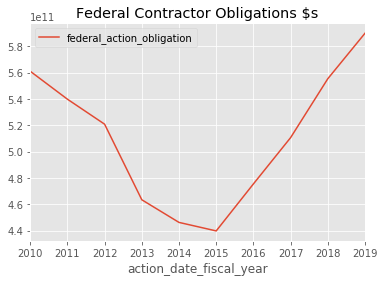

In [270]:
df_GFY_obligations.plot(x='action_date_fiscal_year', y='federal_action_obligation',title="Federal Contractor Obligations $s",grid=True)

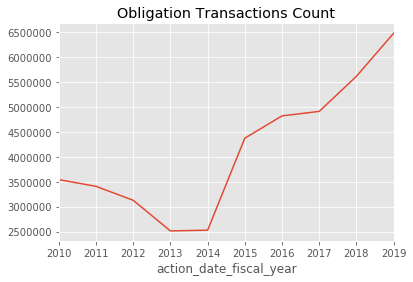

In [271]:
df.groupby(['action_date_fiscal_year'])['federal_action_obligation'].count().plot(title='Obligation Transactions Count', grid=True)

In [46]:
%%time
df_firm_obs = df.groupby(['recipient_parent_name', 'action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

CPU times: user 8.48 s, sys: 271 ms, total: 8.75 s
Wall time: 8.76 s


In [47]:
df_firm_obs.head()

,recipient_parent_name,action_date_fiscal_year,federal_action_obligation
0,!SCITAMEHTAM,2013,0.00
1,"""A"" PLUS CLEANING & RESTORATION, INC.",2015,0.00
2,"""A"" STREET COLLISION INC.",2017,3475.00
3,"""A"" STREET COLLISION INC.",2018,3791.44
4,"""A"" STREET COLLISION INC.",2019,7638.48


In [48]:
df_recipient_per_GFY = df_firm_obs.groupby(['action_date_fiscal_year'])['recipient_parent_name'].count().reset_index()
df_recipient_per_GFY

,action_date_fiscal_year,recipient_parent_name
0,2010,179567
1,2011,177791
2,2012,163406
3,2013,153683
4,2014,152455
5,2015,170433
6,2016,134453
7,2017,138507
8,2018,124803
9,2019,114678


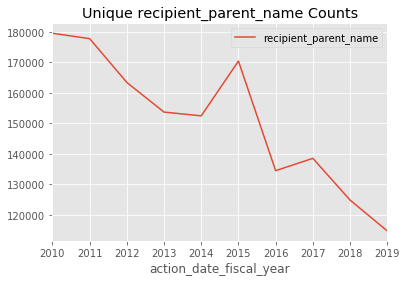

In [272]:
df_recipient_per_GFY.plot(x='action_date_fiscal_year', y='recipient_parent_name', title='Unique recipient_parent_name Counts',grid=True)

## Explore 'Highly Compendated Officer' Data

In [50]:
df.columns

Index(['federal_action_obligation', 'action_date_fiscal_year',
       'funding_agency_name', 'funding_sub_agency_name', 'recipient_name',
       'recipient_parent_name', 'product_or_service_code',
       'product_or_service_code_description',
       'highly_compensated_officer_1_name',
       'highly_compensated_officer_1_amount',
       'highly_compensated_officer_2_name',
       'highly_compensated_officer_2_amount',
       'highly_compensated_officer_3_name',
       'highly_compensated_officer_3_amount',
       'highly_compensated_officer_4_name',
       'highly_compensated_officer_4_amount',
       'highly_compensated_officer_5_name',
       'highly_compensated_officer_5_amount', 'PSC_Cat', 'PSC_Cat_2'],
      dtype='object')

In [51]:
df[df['highly_compensated_officer_1_amount'] == 0.0]['highly_compensated_officer_1_amount'].count()/df['highly_compensated_officer_1_amount'].count()

0.9506528485172259

In [157]:
#df[df['highly_compensated_officer_1_amount'] < 1e5]['highly_compensated_officer_1_amount'].count()/df['highly_compensated_officer_1_amount'].count()

In [53]:
for exec_n in range(1,5):
    numerator_field_name = 'highly_compensated_officer_' + str(exec_n+1) + '_amount'
    new_field_name = 'highly_compensated_officer_1_multiple_vs_officer_n_' + str(exec_n+1)
    df[new_field_name] = df['highly_compensated_officer_1_amount']/df[numerator_field_name]

In [176]:
## Note: the count field is the number of records; NOT the number of unique firms
df.groupby(['action_date_fiscal_year'])['highly_compensated_officer_1_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
action_date_fiscal_year,,,,,,,,
2010,3541570.0,28063.884248,2.035951e+06,0.0,0.0,0.0,0.0,3.063365e+08
2011,3406407.0,21162.657477,1.127029e+06,0.0,0.0,0.0,0.0,3.063365e+08
2012,3126397.0,21442.493925,1.040783e+06,0.0,0.0,0.0,0.0,3.063365e+08
2013,2512001.0,28002.421462,1.290767e+06,0.0,0.0,0.0,0.0,3.063365e+08
2014,2526925.0,30500.695024,1.535733e+06,0.0,0.0,0.0,0.0,3.063365e+08
2015,4373442.0,35604.172796,1.346277e+06,0.0,0.0,0.0,0.0,3.063365e+08
2016,4819816.0,40381.158937,1.214812e+06,0.0,0.0,0.0,0.0,3.063365e+08
2017,4910006.0,29592.454360,1.036584e+06,0.0,0.0,0.0,0.0,3.063365e+08
2018,5613990.0,126179.635783,2.471249e+06,0.0,0.0,0.0,0.0,3.063365e+08


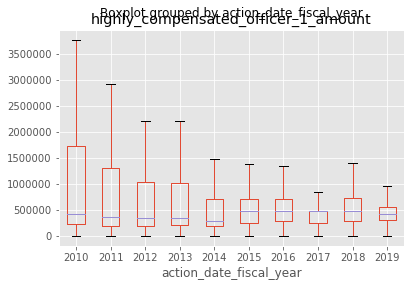

In [186]:
# note addition of , showfliers=False to remove outliers - https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.boxplot.html
df[(df['highly_compensated_officer_1_amount'] > 0.0)].boxplot(column = 'highly_compensated_officer_1_amount', by = 'action_date_fiscal_year', showfliers=False)

In [300]:
# Identify the most common (aka mode) compensation figure for the executive_1 amount
def Get_Mode(compensation_list):
    counts = Counter(compensation_list)
    return counts.most_common(1)[0][0]

query = "action_date_fiscal_year == '2019' and highly_compensated_officer_1_amount > 0.0"
df_exec_1_mode = df.query(query).groupby(['recipient_parent_name'])['highly_compensated_officer_1_amount'].apply(list).apply(Get_Mode).reset_index()

print(f"There are {df_exec_1_mode.shape[0]} firms in GFY2019 with executive 1 compensation reported.")
fraction_of_GFY19_with_exec_1_compensation = df_exec_1_mode.shape[0]/df.query("action_date_fiscal_year == '2019'")['recipient_parent_name'].unique().shape[0]
print(f"Fraction of GFY19 recipient_parent_firms with executive 1 compensation: {fraction_of_GFY19_with_exec_1_compensation}")
fraction_of_GFY19_obligations_actions_with_exec_1_compensation =df.query(query).shape[0]/df.query("action_date_fiscal_year == '2019'").shape[0]
print(f"Fraction of GFY19 obligation transactions with executive 1 compensation: {fraction_of_GFY19_obligations_actions_with_exec_1_compensation}")

There are 2154 firms in GFY2019 with executive 1 compensation reported.
Fraction of GFY19 recipient_parent_firms with executive 1 compensation: 0.01878302725893371
Fraction of GFY19 obligation transactions with executive 1 compensation: 0.10382345535710288


### Caveats: There are errors in the data

Companies self report this information. There are data entry errors and likely some rounding of values

In [236]:
# Example case of the highest compensation listed in the data
df_exec_1_mode[df_exec_1_mode['highly_compensated_officer_1_amount'] == df_exec_1_mode['highly_compensated_officer_1_amount'].max()]

,recipient_parent_name,highly_compensated_officer_1_amount
256,BANK OF NEW YORK MELLON CORPORATION THE,1.908123e+09


In [ ]:
# it is a publicly traded company so one can look up the compensation in SEC reporting

In [261]:
company_name = df_exec_1_mode[df_exec_1_mode['highly_compensated_officer_1_amount'] == df_exec_1_mode['highly_compensated_officer_1_amount'].max()]['recipient_parent_name'].iloc[0]

df[(df['recipient_parent_name'] == company_name) & (df['highly_compensated_officer_1_amount'] > 0.0)]['highly_compensated_officer_1_amount']

33133     1.916560e+07
945542    1.916560e+07
945621    1.348243e+07
945865    1.916560e+07
946227    1.916560e+07
946515    1.916560e+07
243146    1.908123e+09
243869    1.908123e+09
Name: highly_compensated_officer_1_amount, dtype: float64

In [259]:
# The 2018 SEC filing shows the CEO compensation for 2017 closer to $17m (1.7e7)
# SEC document - https://www.sec.gov/Archives/edgar/data/1390777/000119312519069151/d638623ddef14a.htm#toc638623_12
# The 1.9e9 is clearly a typo.
# Also, many of the entries showed no data for the compensation.

### Select subset of Firms with work in PSC_Cat D and R with Exec_1 between 100k and 10M in compensation

In [140]:
# Which companies have work in PSC_Cat D (IT and Telecom) and R (Professional Services)?
recipient_parent_names_with_PSC_Cat_D_R_obligations = df[df['PSC_Cat'].isin(['D','R'])]['recipient_parent_name'].unique()

In [141]:
selector = (df['highly_compensated_officer_1_amount'] > 1e5) & (df['highly_compensated_officer_1_amount'] < 10e6) & (df['recipient_parent_name'].isin(recipient_parent_names_with_PSC_Cat_D_R_obligations))
df_study_subset = df[selector]
df_study_subset.groupby(['action_date_fiscal_year'])['highly_compensated_officer_1_amount'].describe()

,count,mean,std,min,25%,50%,75%,max
action_date_fiscal_year,,,,,,,,
2010,26359.0,1.263430e+06,1.165081e+06,106000.0,325000.0,724551.0,1752711.0,9579597.0
2011,28298.0,1.293969e+06,1.176382e+06,106000.0,324423.0,756106.0,1952016.0,9548116.0
2012,28630.0,1.153685e+06,1.096390e+06,106000.0,272099.0,648022.0,1752711.0,9579597.0
2013,29359.0,1.140280e+06,1.078814e+06,110000.0,273000.0,648022.0,1752711.0,7763213.0
2014,31843.0,1.051055e+06,9.722971e+05,106000.0,320000.0,637001.0,1709906.0,9548116.0
2015,103227.0,9.371178e+05,8.149423e+05,106000.0,486635.0,486635.0,1476987.0,7763213.0
2016,142565.0,9.508760e+05,8.139162e+05,107030.0,486635.0,486635.0,1476987.0,7763213.0
2017,148186.0,7.047720e+05,6.524904e+05,110000.0,486635.0,486635.0,712000.0,9548116.0
2018,410235.0,9.809565e+05,1.027561e+06,100293.0,418212.0,486635.0,1113568.0,9548116.0


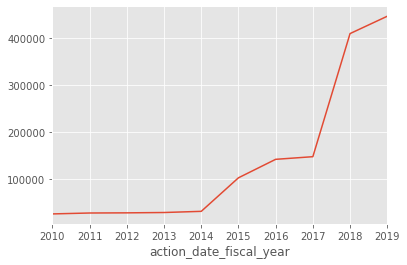

In [142]:
df_study_subset.groupby(['action_date_fiscal_year'])['highly_compensated_officer_1_amount'].describe()['count'].plot(grid=True)

In [143]:
df_study_subset_GFY19 = df_study_subset[df_study_subset['action_date_fiscal_year'] == '2019']
df_study_subset_GFY19.shape

(447156, 24)

In [144]:
df_study_subset_GFY19['recipient_parent_name'].unique().shape

(1410,)

In [145]:
print(f"Our subset has {df_study_subset_GFY19['recipient_parent_name'].unique().shape[0]} parent firms of the {df_exec_1_mode.shape[0]} total firms that reported executive 1 compensation in GFY19.")

Our subset has 1410 parent firms of the 2154 total firms that reported executive 1 compensation in GFY19.


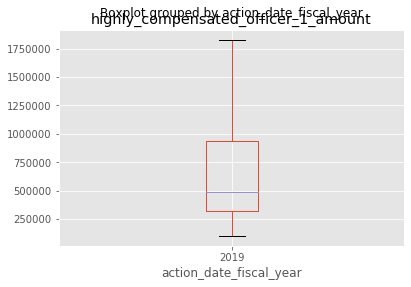

In [188]:
# note addition of , showfliers=False to remove outliers - https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.boxplot.html
df_study_subset_GFY19.boxplot(column = 'highly_compensated_officer_1_amount', by = 'action_date_fiscal_year', showfliers=False)

In [189]:
df_study_subset_GFY19.groupby(['recipient_parent_name'])['federal_action_obligation'].sum().reset_index().describe()

,federal_action_obligation
count,1.410000e+03
mean,9.771901e+07
std,6.340230e+08
min,-5.546343e+08
25%,1.955113e+06
50%,1.981077e+07
75%,5.050977e+07
max,1.971788e+10


In [191]:
# df_study_subset_GFY19_recipient_obs = df_study_subset_GFY19.groupby(['recipient_parent_name'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)
# df_study_subset_GFY19_recipient_obs

In [194]:
df_study_subset_GFY19_exec1 = df_study_subset_GFY19.groupby(['recipient_parent_name'])['highly_compensated_officer_1_amount'].describe().sort_values(by='mean', ascending=False).reset_index()
#Scramble_Company_Exec_Names(df_study_subset_GFY19_exec1)

df_study_subset_GFY19_compensation_obs = df_study_subset_GFY19_recipient_obs.merge(df_study_subset_GFY19_exec1, on='recipient_parent_name').reset_index()
Scramble_Company_Exec_Names(df_study_subset_GFY19_compensation_obs)

,index,recipient_parent_name,federal_action_obligation,count,mean,std,min,25%,50%,75%,max
0,0,Cnpnaedart Oesylrricmo Agnio,1.971788e+10,12710.0,2.629377e+06,8.360443e+05,275000.0,1927593.00,2741945.0,3181559.0,5316668.0
1,1,Huncanmi .a,6.796949e+09,285.0,4.194422e+05,8.257792e+04,361021.0,361021.00,361021.0,458379.0,567725.0
2,2,Semasepslt C By,6.090681e+09,7393.0,3.109920e+06,4.622841e+05,205659.0,2986014.00,2986014.0,3647075.0,4087027.0
3,3,Ninlwlhno Oree.ttna Cynieial,3.729625e+09,24.0,1.620716e+06,7.109492e+04,1475000.0,1643717.00,1643717.0,1643717.0,1766554.0
4,4,Otgeicieiea Engtrcronlpona Carlso Oohmt,3.458976e+09,832.0,2.106536e+06,3.751620e+05,196863.0,2273957.00,2306758.0,2306758.0,2306758.0
5,5,Brpo Euhcc.eln Tg I,3.219545e+09,69.0,1.452079e+06,7.833689e+05,474620.0,753632.00,2151675.0,2151675.0,2976650.0
6,6,Nnlagp .tcpcy S Uidiivlntia,3.206749e+09,47587.0,2.067218e+06,5.154583e+05,1476987.0,1752711.00,1752711.0,2811112.0,2811112.0
7,7,Cp Al.cwoeartearhetiancslitr Hle,2.869991e+09,69.0,6.340032e+06,0.000000e+00,6340032.0,6340032.00,6340032.0,6340032.0,6340032.0
8,8,Crnkib .,2.550350e+09,1899.0,1.847404e+06,7.426255e+05,351590.0,1688065.00,1695749.0,1695749.0,3771119.0
9,9,Intacoreeonenrtopc,2.309316e+09,85.0,4.286329e+06,1.395931e+06,960489.0,4962844.00,4962844.0,4962844.0,4962844.0


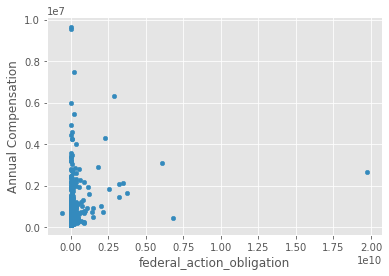

In [150]:
df_study_subset_GFY19_compensation_obs.plot.scatter(x='federal_action_obligation', y='mean', grid=True)
plt.ylabel("Annual Compensation")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

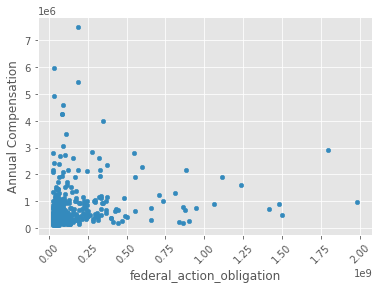

In [151]:
selector = (df_study_subset_GFY19_compensation_obs['federal_action_obligation'] > 25e6) & (df_study_subset_GFY19_compensation_obs['federal_action_obligation'] < 2e9)
df_study_subset_GFY19_compensation_obs[selector].plot.scatter(x='federal_action_obligation', y='mean', grid=True, rot=45)
plt.ylabel("Annual Compensation")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

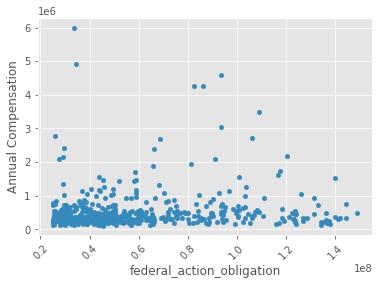

In [152]:
selector = (df_study_subset_GFY19_compensation_obs['federal_action_obligation'] > 25e6) & (df_study_subset_GFY19_compensation_obs['federal_action_obligation'] < 150e6)
df_study_subset_GFY19_compensation_obs[selector].plot.scatter(x='federal_action_obligation', y='mean', grid=True, rot=45)
plt.ylabel("Annual Compensation")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

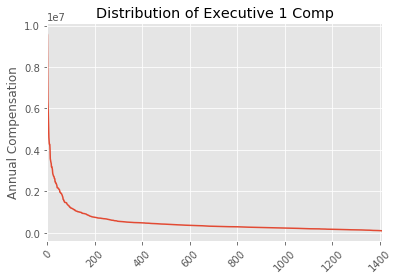

In [153]:
df_study_subset_GFY19_exec1['mean'].plot(title="Distribution of Executive 1 Comp", grid=True, rot=45)
plt.ylabel("Annual Compensation")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#axes = plt.axes()
#axes#.get_xaxis().set_visible(False) #https://stackoverflow.com/questions/40705614/hide-axis-label-only-not-entire-axis-in-pandas-plot

### Executive_1 Compensation as a Fraction of Total Federal Obligations

In [154]:
df_study_subset_GFY19_compensation_obs['exec_1_comp_fraction_obligations'] = df_study_subset_GFY19_compensation_obs['mean']/df_study_subset_GFY19_compensation_obs['federal_action_obligation']
selector = (df_study_subset_GFY19_compensation_obs['exec_1_comp_fraction_obligations'] > 0.0) & (~df_study_subset_GFY19_compensation_obs['exec_1_comp_fraction_obligations'].isin([np.inf]))
df_study_subset_GFY19_compensation_obs[selector]['exec_1_comp_fraction_obligations'] #.hist()

# Which have exec_1 compensation 10% or higher of total prime obligations?
# some of these may be coding errors and others may be companies with a small fraction of revenue from USApsneding.gov-reported Federal obligations
selector = (df_study_subset_GFY19_compensation_obs['exec_1_comp_fraction_obligations'] > 0.1) & (~df_study_subset_GFY19_compensation_obs['exec_1_comp_fraction_obligations'].isin([np.inf]))
Scramble_Company_Exec_Names(df_study_subset_GFY19_compensation_obs[selector])[['recipient_parent_name', 'federal_action_obligation', 'exec_1_comp_fraction_obligations']]

,recipient_parent_name,federal_action_obligation,exec_1_comp_fraction_obligations
518,Os Dnogpieilrars.rch,34389540.24,0.142885
523,Rm. Ncninicnaln Tieao Oliptci,33848885.36,0.177005
610,N S E Ddorpnsg.uaciievfe,25828211.82,0.107825
632,Nrc Ermocn Rcipenseeae Itreuofrprse,24633249.68,0.179766
646,M.rs T Arehr Nmcntievoeeianen Sgcn,23788559.16,0.100902
698,Prly Uoccbel Esscotlians,20416302.08,0.163350
801,Laltlsnu Lntioal C Ois,12702238.00,0.250472
815,Tilrecoerilstlrnspus Seh S Ocemcvae,11839973.32,0.111500
832,Isluo Tolne Ss.nrtalci,10634615.93,0.256789
836,Meit Nrrm E Ieros .coaal-lyrihnoncacr,10376478.84,0.118362


In [155]:
#df_study_subset_GFY19[~df_study_subset_GFY19['highly_compensated_officer_1_multiple_vs_officer_n_2'].isin([np.nan, np.inf, -np.inf])]['highly_compensated_officer_1_multiple_vs_officer_n_2'].describe()

In [156]:
df_temp = df_study_subset_GFY19.groupby(['recipient_parent_name','highly_compensated_officer_1_name'])['highly_compensated_officer_1_amount'].mean().sort_values(ascending=False).reset_index()
Scramble_Company_Exec_Names(df_temp).head(10)

,recipient_parent_name,highly_compensated_officer_1_name,highly_compensated_officer_1_amount
0,Rcee Nnnmtesev Ogrirrnv Ceesci.,Rerf Tn Seabh,9.633001e+06
1,Ovtihel Oc Lnrleoe Sgkac. Go,Rosasrk Gm,9.548116e+06
2,A Slsf Ncadsotrahclaeealik,Falhekaa Dwrn,7.489787e+06
3,Wtatlrecoecc Rhtia E Pshar.ilaenl,Advine Jrtyc Dim,6.340032e+06
4,Clcitican.np Aliitomo Innnr E,H Ineacruhd Scdislh,5.991407e+06
5,C Rsmsseinimyna Niotcto.inf,An Esllucarj,5.736979e+06
6,Ntecqit Cihnua,Wbarnsiohl E,5.466806e+06
7,Yacn Rolr Ctgpsarnnieeiadomo,Dajo In Nenhlos,5.124830e+06
8,Ioc Dape Raatnnonlesrrcgmiyo,Olnode Snh Ansji,4.984412e+06
9,Eeoactteror Pniconn,E S Ntnjrueseh,4.962844e+06


### Explore the relative compensation of the top 5 executives

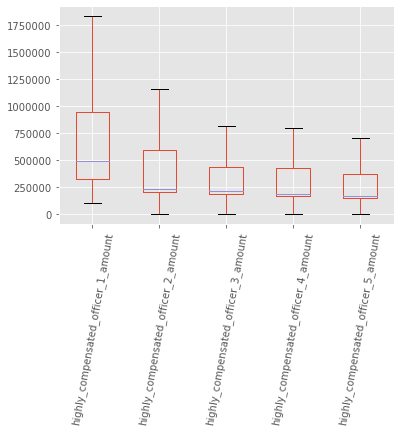

In [221]:
# note addition of , showfliers=False to remove outliers - https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.boxplot.html
boxplot_columns = ['highly_compensated_officer_' + str(n) + '_amount' for n in range(1,6)]
df_study_subset_GFY19.boxplot(column = boxplot_columns,  showfliers=False, rot=80)

In [222]:
df_study_relative_comp = df_study_subset_GFY19[['recipient_parent_name'] + boxplot_columns].drop_duplicates()

In [223]:
exec_multiple_fields = []
for n in range(2,6):
    field_name = 'highly_compensated_officer_' + str(n) + '_amount'
    new_field = 'exec1_multiple_exec_' + str(n)
    exec_multiple_fields.append(new_field)
    df_study_relative_comp[new_field] = df_study_relative_comp['highly_compensated_officer_1_amount']/df_study_relative_comp[field_name]

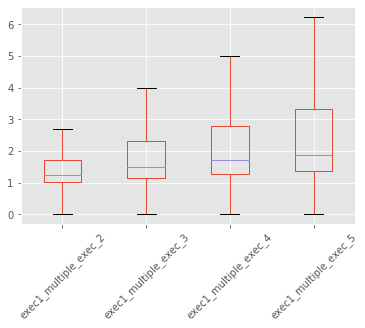

In [224]:
df_study_relative_comp.boxplot(column = exec_multiple_fields, showfliers=False, rot=45)

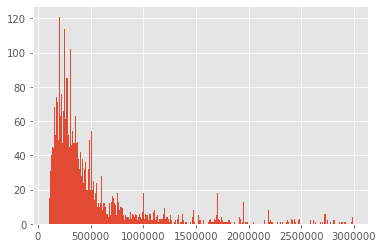

In [299]:
bins = list(range(100000, 3000000, 10000))
df_study_relative_comp['highly_compensated_officer_1_amount'].hist(bins=bins)

In [293]:
# $1m/year or greater
selector = (df_study_relative_comp['highly_compensated_officer_1_amount'] >= 1e6)
df_study_relative_comp[selector]['recipient_parent_name'].unique().shape[0]

186

In [294]:
# Between $500k/year-$1M/year
selector = (df_study_relative_comp['highly_compensated_officer_1_amount'] >= 0.5e6) & ((df_study_relative_comp['highly_compensated_officer_1_amount'] < 1e6))
df_study_relative_comp[selector]['recipient_parent_name'].unique().shape[0]

323

In [295]:
# Between less than $500k/year
selector = (df_study_relative_comp['highly_compensated_officer_1_amount'] < 0.5e6)
df_study_relative_comp[selector]['recipient_parent_name'].unique().shape[0]

1123

In [290]:
df_study_relative_comp['recipient_parent_name'].unique().shape[0]

1410

## Assuming you can clean up the data sufficiently and the business is mostly Federal, can an analyst use the Top 5 compensation data to estimate profit margins of your competitors?

# Analysis End

In [1]:
# https://opensource.org/licenses/MIT

# MIT Open Source License
# Copyright 2020 Leif C Ulstrup

# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
